# Dermatologist Sample Problem
This is the optional problem provided in module 3 of the Udacity Deep Learning nanodegree program.  I am building it on my own, after completing the course.

I'm trying to decide on a process flow.  Here I'll use the following phases:
1. Project setup & acquire data
2. Load & prepare the data (includes spot checking & sanity checking for cleanliness & appropriate content)
3. Build the model
4. ?

**Phase 1:** 
Data, provided by Udacity, already exists elsewhere in my local directory.  So this is probably a lot shorter than it would normally be.  This data set comes from [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection] (https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a).

**Phase 2:**
* These images are large, and vary in size.  Since I'm looking for lots of details to help improve classification, I don't want to throw away lots of info by unnecessarily croping or downsampling the images. Therefore, I first need to go through the data set and figure out the min/max sizes.  From there I can figure out what is possible.
* Consisder using scaling like what is found in https://opensource.com/life/15/2/resize-images-python

In [7]:
HEIGHT_GOAL = 768 #pixels

In [8]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    

# define training and test data directories
data_dir = '/home/starkj/Udacity/Module3/dermatologist-ai/data/'
train_dir = os.path.join(data_dir, 'train/')
val_dir   = os.path.join(data_dir, "valid/")
test_dir  = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

# load and transform data using ImageFolder

# load and transform data using ImageFolder
### NOTE:  very important!  Some transforms work on PIL images and some on tensors.  Apply all the
###        PIL transforms first, then convert the result to a Tensor, then we can apply further
###        transforms if desired.

# VGG-16 Takes 224x224 images as input, so we resize all of them
image_size = HEIGHT_GOAL
print("Using image size: ", image_size)

full1 = transforms.Compose([transforms.RandomResizedCrop(image_size), 
                                     transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                                            saturation=0.2, hue=0.2),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAffine(degrees=30, translate=(0.2, 0.2),
                                                             scale=(0.2, 0.2)),
                                     transforms.ToTensor()])
no_xform = transforms.ToTensor()
crop_only = transforms.Compose([transforms.CenterCrop(image_size),
                                transforms.ToTensor()])

data_transform = no_xform

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data   = datasets.ImageFolder(val_dir, transform=data_transform)
test_data  = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images:   ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num test images:       ', len(test_data))
print('training data = ', train_data)


CUDA is not available.  Training on CPU ...
Using image size:  768
Num training images:    2000
Num validation images:  150
Num test images:        600
training data =  Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /home/starkj/Udacity/Module3/dermatologist-ai/data/train/
    StandardTransform
Transform: ToTensor()


In [9]:
##### data exploration support function
class ImageDatasetStats:
    def __init__(self):
        self.min_w  = 99999
        self.min_w2 = 99999 #second smallest
        self.max_w  = 0
        self.max_w2 = 0 #second largest
        self.min_h  = 99999
        self.min_h2 = 99999
        self.max_h  = 0
        self.max_h2 = 0

    # accessors
    def get_min_w(self):
        return (self.min_w, self.min_w2)

    def get_max_w(self):
        return (self.max_w, self.max_w2)

    def get_min_h(self):
        return (self.min_h, self.min_h2)

    def get_max_h(self):
        return (self.max_h, self.max_h2)
    
    # set the first and/or second smallest min dimension if new item exceeds
    def adjust_mins(self, min1, min2, val):
        if val < min1:
            min2 = min1
            min1 = val
        elif val < min2:
            min2 = val
        return (min1, min2)

    # set the first and/or second largest max dimension if new item exceeds
    def adjust_maxs(self, max1, max2, val):
        if val > max1:
            max2 = max1
            max1 = val
        elif val > max2:
            max2 = val
        return (max1, max2)

    # iterate through an image dataset, finding the first and second largest and smallest values in each dimension
    # (width and height)
    #    data: ImageFolder
    def find2dim_extremes(self, data):
        for i in range(len(data)):
            im = train_data.__getitem__(i)[0]
            h = im.shape[1]
            w = im.shape[2]
            mins = self.adjust_mins(self.min_w, self.min_w2, w)
            maxs = self.adjust_maxs(self.max_w, self.max_w2, w)
            self.min_w  = mins[0]
            self.min_w2 = mins[1]
            self.max_w  = maxs[0]
            self.max_w2 = maxs[1]
            
            mins = self.adjust_mins(self.min_h, self.min_h2, h)
            maxs = self.adjust_maxs(self.max_h, self.max_h2, h)
            self.min_h  = mins[0]
            self.min_h2 = mins[1]
            self.max_h  = maxs[0]
            self.max_h2 = maxs[1]

            if i%10 == 0:
                print(".", end = "")
            '''
            print("\nimage shape = ", im.shape)
            print("w = ", w, ", h = ", h)
            print("width mins & maxes = ", self.min_w, self.min_w2, self.max_w, self.max_w2)
            print("height mins & maxs = ", self.min_h, self.min_h2, self.max_h, self.max_h2)
            '''
   
    # iterate through a dataset and count how many images are in each size bin, both height & width
    # data: a DataSet of images
    def generate_histogram(self, minw, maxw, minh, maxh, num_bins, data):
        w_bin_width = int((maxw - minw)/num_bins)
        h_bin_width = int((maxh - minh)/num_bins)
        
        # initialize the arrays that will count the number of items in each size bin
        w_count = []
        h_count = []
        for i in range(num_bins):
            w_count.append(0)
            h_count.append(0)
        
        # determine the boundaries of each width bin
        w_bin_upper_bound = []
        for i in range(num_bins):
            w_bin_upper_bound.append(minw + (i+1)*w_bin_width - 1)
        w_bin_upper_bound[num_bins-1] = maxw #adjust size of final bin to account for bin width rounding
        #print("w_bin_upper_bound = ", w_bin_upper_bound)
        
        # determine the boudnaries of each height bin
        h_bin_upper_bound = []
        for i in range(num_bins):
            h_bin_upper_bound.append(minh + (i+1)*h_bin_width - 1)
        h_bin_upper_bound[num_bins-1] = maxh #adjust size of final bin to account for bin width rounding
        #print("h_bin_upper_bound = ", h_bin_upper_bound)
        
        # count the number of images that fall into each bin
        dsize = len(data)
        print("Binning images in dataset size ", dsize)
        for i in range(dsize):
            im = data.__getitem__(i)[0]
            h = im.shape[1]
            w = im.shape[2]
            #print("Image ", i, ": h = ", h, ", w = ", w)

            for j in range(num_bins):
                if w <= w_bin_upper_bound[j]:
                    w_count[j] += 1
                    break
            for j in range(num_bins):
                if h <= h_bin_upper_bound[j]:
                    h_count[j] += 1
                    break
        return w_count, h_count, w_bin_upper_bound, h_bin_upper_bound


In [10]:
##### data exploration only
'''

print("train_data shape = ", type(train_data))

# Make a loop to look at each image and determine range of sizes
stats = ImageDatasetStats()
stats.find2dim_extremes(train_data)
minw = stats.get_min_w()
maxw = stats.get_max_w()
minh = stats.get_min_h()
maxh = stats.get_max_h()
print(" ")
print("Width extremes  = ", minw, maxw)
print("Height extremes = ", minh, maxh)
'''


train_data shape =  <class 'torchvision.datasets.folder.ImageFolder'>
........................................................................................................................................................................................................ 
Width extremes  =  (576, 576) (6748, 6728)
Height extremes =  (540, 542) (4499, 4477)


### Handling variable image sizes

Clearly, from above, we have a wide range of image sizes, by almost 10x.  Cropping is not a good answer to this, because many of the images are framed tightly around the artifact of interest, so even a little cropping will be throwing away valuable information.  Other alternatives, which might be combined:

1) Downsample the larger images - probably useful for a certain range of downsampling (e.g. up to 4x?) but we stand to lose too much info in the largest images if they are downsampled a lot.  See https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html

2) Throw out the smallest and/or largest images as outliers - if there are only a few way out on the tails of the distribution, this could help reduce the magnitude of the problem, but the statistics above only show that there are at least two images at each of the very extremes.

3) Build a network that handles variable image sizes - there are some techniques for this, but it involves advanced CNN construction, and adds difficulty to the final FC classification layer.  See:
    * https://stats.stackexchange.com/questions/388859/is-it-possible-to-give-variable-sized-images-as-input-to-a-convolutional-neural
    * https://www.reddit.com/r/MachineLearning/comments/akbe39/d_best_approach_to_variable_image_sizes_for_image/
    * Thesis paper in Downloads folder.

In [11]:
##### data exploration only
'''
stats = ImageDatasetStats()
res = stats.generate_histogram(576, 6748, 540, 4499, 11, train_data)

print("width counts = ", res[0])
print("width Ubound = ", res[2])
print("height counts =", res[1])
print("height Ubound =", res[3])
'''

Binning images in dataset size  2000
width counts =  [727, 65, 62, 80, 414, 96, 418, 0, 1, 0, 137]
width Ubound =  [1136, 1697, 2258, 2819, 3380, 3941, 4502, 5063, 5624, 6185, 6748]
height counts = [726, 66, 68, 62, 426, 96, 418, 0, 1, 0, 137]
height Ubound = [898, 1257, 1616, 1975, 2334, 2693, 3052, 3411, 3770, 4129, 4499]


### More on variable image sizes
As the cell above shows, the distribution is far from Gaussian, with ~1/3 of all the images in the lowest size bin.  The upper four size bins combined are about 7% of the images in the training set.  Therefore, for the sake of what is supposed to be a fairly simple exercise here, I'll ignore images with w > 4502 or h > 3052 pixels.  For the remainder, I'll downsample the larger ones and pad the smaller ones.  Since most of the images are in the smallest bin, I don't want to perturb them too much.  The smallest being h=540 and w=576, it probably isn't prudent to pad more than 30%, so set my input image size to 700x748 pixels.  Anything smaller will be padded; anything larger will be downsampled and/or cropped.

Problem is, the standard DataLoader won't accept input images that have variable sizes, per below, so need to figure out how to get around that.

In [12]:
##### data exploration only - can't use this as is
'''

# This code fragment pulled from Udacity DLND module 3 homework.
# Note that it only works if all images are identical size (dataiter assumes this)

import matplotlib.pyplot as plt

%matplotlib inline

# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# obtain one batch of training images
dataiter = iter(train_loader) ######### THIS LINE BREAKS - can't handle variable image sizes
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print("images shape = ", images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
'''


RuntimeError: stack expects each tensor to be equal size, but got [3, 2592, 3872] at entry 0 and [3, 768, 1024] at entry 1

### Loading image data of variable sizes

* There is an interesting answer for how to do this at https://discuss.pytorch.org/t/torchvision-and-dataloader-different-images-shapes/41026/3. Code from this page is copied below for ease of reading (without scroll bars).
* Another, maybe more useful answer, with links to lots of other answers: https://stackoverflow.com/questions/55041080/how-does-pytorch-dataloader-handle-variable-size-data

In [13]:
##### for image exploration only
### I don't think I want to use this, as it has masks that appear to be a substitute for resizing the images,
### but it looks like it requires each image to be in a fixed size tensor, which I don't want to do.

def default_collate(batch):
    """
    Override `default_collate` https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader

    Reference:
    def default_collate(batch) at https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader
    https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3
    https://github.com/pytorch/pytorch/issues/1512

    We need our own collate function that wraps things up (imge, mask, label).

    In this setup,  batch is a list of tuples (the result of calling: img, mask, label = Dataset[i].
    The output of this function is four elements:
        . data: a pytorch tensor of size (batch_size, c, h, w) of float32 . Each sample is a tensor of shape (c, h_,
        w_) that represents a cropped patch from an image (or the entire image) where: c is the depth of the patches (
        since they are RGB, so c=3),  h is the height of the patch, and w_ is the its width.
        . mask: a list of pytorch tensors of size (batch_size, 1, h, w) full of 1 and 0. The mask of the ENTIRE image (no
        cropping is performed). Images does not have the same size, and the same thing goes for the masks. Therefore,
        we can't put the masks in one tensor.
        . target: a vector (pytorch tensor) of length batch_size of type torch.LongTensor containing the image-level
        labels.
    :param batch: list of tuples (img, mask, label)
    :return: 3 elements: tensor data, list of tensors of masks, tensor of labels.
    """
    data = torch.stack([item[0] for item in batch])
    mask = [item[1] for item in batch]  # each element is of size (1, h*, w*). where (h*, w*) changes from mask to another.
    target = torch.LongTensor([item[2] for item in batch])  # image labels.

    return data, mask, target

In [14]:
import PIL
from PIL import Image

# Defining a custom collator for the DataLoader since its default assumes all raw images are identical
# size.  In our case they are not.  This function not only loads different size images, but manipulates
# them to be identical size (downsampling and cropping), because the CNN being used in this project
# is assuming that all images are identical size.
# This function is modified from https://jdhao.github.io/2017/10/23/pytorch-load-data-and-make-batch/
#
# `batch` is a list of tuple where first element is image tensor and
# second element is corresponding label
#
# return is a tuple of (data, target), where data is a tensor of shape [b, c, h, w] and
# target is a list of labels

AR_GOAL = 1.333333 # represents 768x1024
WIDTH_GOAL = HEIGHT_GOAL * AR_GOAL

def variable_collate(batch):
    data_list = []
    for item in batch:
        
        # get info on the raw image shape
        raw_image = item[0]
        h = raw_image.shape[1]
        w = raw_image.shape[2]
        ar = w/h
        
        # if the aspect ratio is larger than desired, then we scale by the height, otherwise by width
        if ar > AR_GOAL:
            scale_factor = HEIGHT_GOAL / h
        else:
            scale_factor = WIDTH_GOAL / w
        #print("In variable_collate: raw h = ", h, ", w = ", w, ", scale_factor = ", scale_factor)
        #print("  raw_image = ", raw_image.shape)
            
        # convert the raw_image tensor into a PIL Image object
        image = transforms.ToPILImage()(raw_image.squeeze_(0))
        #print("  After transform, image = ", image.size)
        
        # scale it, preserving aspect ratio
        resized = image.resize((int(w*scale_factor), int(h*scale_factor)))
        width = resized.width
        height = resized.height
        #print("  resized w = ", width, ", h = ", height)
            
        # now we have an image that doesn't necessarily match our goal aspect ratio, but is at least
        # as large as our goal dimensions in both directions; need to center-crop it - 
        # DON'T try to make it square!
        if width > WIDTH_GOAL:
            left = (width - WIDTH_GOAL) // 2
        else:
            left = 0
        right = left + WIDTH_GOAL #don't subtract 1; this is the next pixel beyond the edge of the image
        
        if height > HEIGHT_GOAL:
            upper = (height - HEIGHT_GOAL) // 2
        else:
            upper = 0
        lower = upper + HEIGHT_GOAL #don't subtract 1
        #print("  cropping to left = ", left, ", right = ", right, ", upper = ", upper, ", lower = ", lower)
        
        cropped_image = resized.crop((left, upper, right, lower))
        
        # convert the properly sized image back to a tensor
        cropped_tensor = transforms.ToTensor()(cropped_image).unsqueeze_(0)
        data_list.append(cropped_tensor)
        #print("  cropped_tensor = ", cropped_tensor.shape)
        

    # assemble all of the images into the data tensor for output
    data = torch.stack(data_list).squeeze()
    #print("  returning data = ", data.shape)
    
    # gather the target labels for each image
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    
    return [data, target]

In [15]:
# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, collate_fn=variable_collate, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data, collate_fn=variable_collate, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, collate_fn=variable_collate, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)



  returning data =  torch.Size([32, 3, 768, 1024])
images type from dataiter =  <class 'torch.Tensor'>
images shape =  (32, 3, 768, 1024)


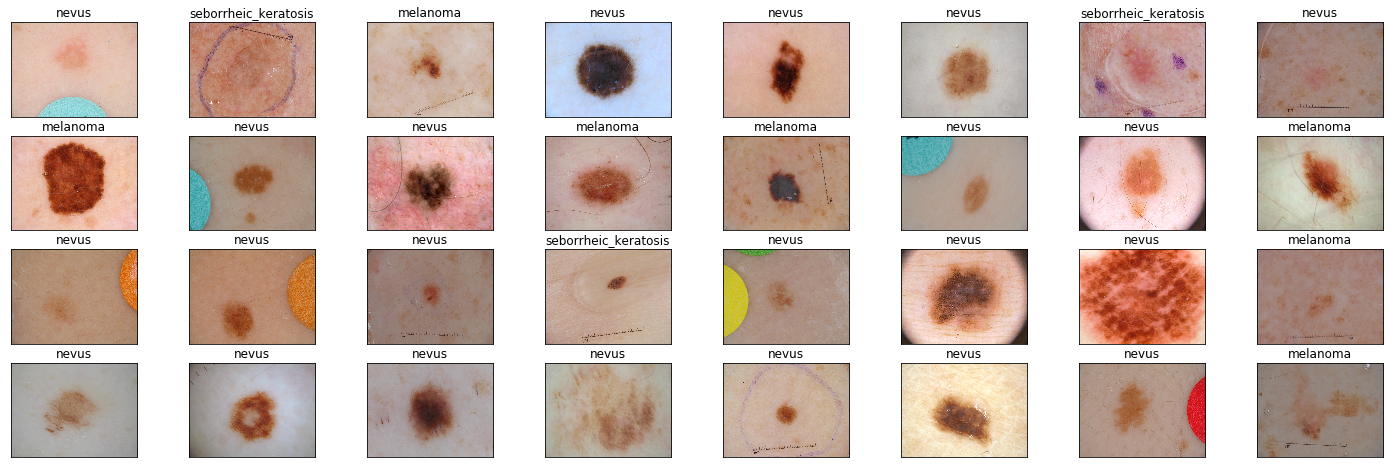

In [16]:
# This code fragment pulled from Udacity DLND module 3 homework.
# Note that it only works if all images are identical size (dataiter assumes this)

import matplotlib.pyplot as plt

%matplotlib inline

# obtain one batch of training images - these need to be in a tensor of shape [b, c, w, h]
dataiter = iter(train_loader)
images, labels = dataiter.next()
print("images type from dataiter = ", type(images))
images = images.numpy() # convert images to numpy for display
print("images shape = ", images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8)) #numbers indicate horiz & vert spacing between images
for idx in np.arange(32):
    ax = fig.add_subplot(4, 32/4, idx+1, xticks=[], yticks=[]) #num rows, num images/row
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


So these images look pretty good!  Sizes of the objects of interest aren't as uniform as I'd like, but for the purposes of this exercise, I think close enough.  To get better, it's probably worth doing some pre-processing with some sort of edge/feature detection to define a bounding box in the raw image, then crop around that before doing the scaling I've done here.  

## Constructing the Model

I would like to use transfer learning with one of the big CNN's, but I need one that will use my chosen image size, or something close to it.
* VGG uses 224x224
* ResNet50 - not clear, but it looks like it can handle different sizes, up to 640 on short side.
* GoogLeNet 50 appears to take 224x224 also.

I'm starting to think all of these models are built for 224 square as a de facto standard for benchmarking.  Therefore, I choose to write my own model from scratch.  There is no doubt it will perform much worse than these world class models, but it will have one advantage in being able to use more input data (more pixels in the input images).

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class SkinCancerCnn(nn.Module):
    def __init__(self):
        super(SkinCancerCnn, self).__init__()
        
        self.CONV_OUT_FEATURES = int(128 * (768/2/2/2/2/2) * (1024/2/2/2/2/2))
        print("CONV_OUT_FEATURES = ", self.CONV_OUT_FEATURES)
        
        #input images are 768x1024 pixels, full coloer (3 channels)
        self.c1 = nn.Conv2d(3, 8, 2, padding=1) #stride = 1
        self.c2 = nn.Conv2d(8, 16, 2, padding=1)
        self.c3 = nn.Conv2d(16, 32, 2, padding=1)
        self.c4 = nn.Conv2d(32, 64, 2, padding=1)
        self.c5 = nn.Conv2d(64, 128, 2, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        #linear classifier
        self.fc1 = nn.Linear(self.CONV_OUT_FEATURES, 1024)
        self.fc2 = nn.Linear(1024, 3)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.c1(x)) #output 8 x 768 x 1024
        x = self.pool(x)       #output 8 x 384 x 512
        
        x = F.relu(self.c2(x)) #ouptut 16 x 384 x 512
        x = self.pool(x)       #output 16 x 192 x 256
        
        x = F.relu(self.c3(x)) #output 32 x 192 x 256
        x = self.pool(x)       #output 32 x 96 x 128
        
        x = F.relu(self.c4(x)) #output 64 x 96 x 128
        x = self.pool(x)       #output 64 x 48 x 64
        
        x = F.relu(self.c5(x)) #output 128 x 48 x 64
        x = self.pool(x)       #output 128 x 24 x 32
        
        conv_out = x.shape[1] * x.shape[2] * x.shape[3]
        #print("forward: after conv, x.shape = ", x.shape, "conv_out = ", conv_out)
        
        x = x.view(x.shape[0], -1) #flatten the convolved image
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # softmax will be applied during training (as part of loss function), not here
        
        return x
    

In [31]:
# Train the model

model = SkinCancerCnn()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

num_epochs = 2

print("Entering training loop.")
model.train() #put it into training mode
for epoch in range(num_epochs):
    train_loss = 0.0
    
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    train_loss /= len(train_loader.dataset)
    
    print("///// Epoch {}: loss = {:.6f}".format(epoch, train_loss))
    
print("Done training.")

CONV_OUT_FEATURES =  98304
SkinCancerCnn(
  (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Entering training loop.
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024

forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([16, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([16, 128, 24, 32]) conv_out =  98304
///// Epoch 0: loss = 1.098773
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128,

  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([32, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([32, 128, 24, 32]) conv_out =  98304
  returning data =  torch.Size([16, 3, 768, 1024])
forward: after conv, x.shape =  torch.Size([16, 128, 24, 32]) conv_out =  98304
///// Epoch 1: loss = 0.914139
Done training.


### Using AWS
Ran the above code for 2 epochs on the local computer to determine that the model is functional and seems to be trainable (loss decreased).

Now it's time to move it to an AWS instance in order to train.  I discovered my existing instance does not have any storage attached (I had been using a separate EBS volume, and deleted it after class).  Therefore, choosing a new instance:  <code>g2.2xlarge</code>, which has 1 GPU and 2 cores of CPU (2 threads each) and 16 GB of memory.

System volume is /dev/sda1.  Working data storage is on /dev/sdb (60 GB).  Instance ID is i-0be255fe5cb1becf1.  Username is default "ubuntu".  Changed pwd to H1.